In [1]:
import pandas as pd
import numpy as np
import time
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#### **一、读取数据**

In [ ]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
test.insert(1, "target", -1)
data_df = pd.concat([train, test], axis=0)
data_var = data_df.drop(["ID_code", "target"], axis=1)
var_leng = data_var.shape[1]
column = list(data_df.columns)
var_start = column.index("var_0")

#### **二、特征工程**

In [ ]:
def deep_feat_one(data):
    data_var = data.drop(["ID_code", "target"], axis=1)
    var_leng = data_var.shape[1]
#     column=list(data.columns)
#     var_start = column.index('var_0')
#     data["mean"] = np.mean(data.ix[:, var_start:var_start+var_leng], 1)
#     data["max"] = np.max(data.ix[:, var_start:var_start+var_leng], 1)
#     data["min"] = np.min(data.ix[:, var_start:var_start+var_leng], 1)
#     data["sum"] = np.sum(data.ix[:, var_start:var_start+var_leng], 1)
#     data["std"] = np.std(data.ix[:, var_start:var_start+var_leng], 1)
#     data["med"] = np.median(data.ix[:, var_start:var_start+var_leng], 1)
#     data["var"] = np.var(data.ix[:, var_start:var_start+var_leng], 1)
        
    feats = data.columns.values[2:202]
    data["max"] = data[feats].max(axis=1)
    data["min"] = data[feats].min(axis=1)
    data["sum"] = data[feats].sum(axis=1)
    data["mean"] = data[feats].mean(axis=1)
    data["std"] = data[feats].std(axis=1)
    data["var"] = data[feats].var(axis=1)
    data["med"] = data[feats].median(axis=1)
    data["skew"] = data[feats].skew(axis=1)
    data["kurt"] = data[feats].kurt(axis=1)
    for i in range(var_leng-1):
        data_var["ratio_"+str(i)] = data_var.iloc[:,i+1] / data_var.iloc[:,i]
    for i in range(var_leng-1):
        data_var["normal_"+str(i)] = (data_var.iloc[:,i]-data["min"])/(data["max"]-data["min"])
    for i in range(var_leng-1):
        data_var["stand_"+str(i)] = (data_var.iloc[:,i]-data["mean"])/data["std"]

    column=list(data_var.columns)
    ratio_start = column.index('ratio_0')
    ratio_end = ratio_start+var_leng-1
    data_ratio = data_var.ix[:,ratio_start:ratio_end]
    n_ratio = data_ratio.shape[1]
    for i in range(n_ratio-1):
        data_var["accel_"+str(i)] = data_ratio.iloc[:,i+1] / data_ratio.iloc[:,i]

    data_var_new = data_var.iloc[:,ratio_start:]
    data_new = pd.concat([data, data_var_new], axis=1)
    
    return data_new

In [ ]:
data_one = deep_feat_one(data_df)

#### xgb模型

In [ ]:
train_df = data_one[data_one["target"] != -1]
test_df = data_one[data_one["target"] == -1]
test_df = test_df.drop(["target"], axis=1)
X_train = train_df.drop(["ID_code","target"], axis=1)
y_train = train_df["target"]
x_tra, x_val, y_tra, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=2019)

x_test = test_df.drop(["ID_code"], axis=1)

del data_one
import xgboost as xgb
params = {"booster": "gbtree",
          "objective" : "binary:logistic",
          "eval_metric" : "auc",
          "verbose" : 1, 
          "eta" : 0.01, 
          "max_delta_step" : 5, 
          "max_depth" : 20, 
          "alpha" : 10, 
          "lambda" : 10, 
          "gamma" : 2, 
          "subsample" : 0.8, 
          "colsample_bylevel" : 0.8, 
          "min_child_weight" : 5, 
          "scale_pos_weight" : 0.8,
          "n_jobs" : -1}

matrix_tra = xgb.DMatrix(x_tra, y_tra)
matrix_val = xgb.DMatrix(x_val)
a_model = xgb.train(params, matrix_tra, num_boost_round=5000)
y_pred = a_model.predict(matrix_val)

matrix_train = xgb.DMatrix(X_train, y_train)
matrix_test = xgb.DMatrix(x_test)
a_model = xgb.train(params, matrix_train, num_boost_round=5000)
prob = a_model.predict(matrix_test)


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.5f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGB_" + "ROC")
plt.legend(loc="lower right")
plt.show()


In [ ]:
import seaborn as sns
#计算特征重要性
importance = a_model.get_fscore()
temp1 = [] 
temp2 = [] 
for k in importance:
    temp1.append(k)
    temp2.append(importance[k]) 
feat_import = pd.DataFrame({'feature': temp1, 'importance': temp2}).sort_values(by='importance', ascending=False)
# feat_import.to_csv("../data_output/feat_import_didi.csv", index=False)

# 画出特征重要性图
plt.style.use('ggplot')
cols = (feat_import[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:20].index)

best_features = feat_import.loc[feat_import.feature.isin(cols)]
plt.figure(figsize=(8,10))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGB Features Importance', fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("importance", fontsize=20)
plt.ylabel("feature", fontsize=20)
plt.tight_layout()
# plt.savefig("../fig_out_2/xgb_importances_didi_"+datestr+".png")
plt.show()

In [ ]:
ID_code = test["ID_code"]
result = pd.DataFrame({"ID_code":ID_code, "target":prob})
result.to_csv("../submission/result.csv", index=False)

In [ ]:
data_one.to_csv("./data_one.csv", index=False)

#### **三、建立模型**

##### 3.1、模型一

In [ ]:
train_df = data_one[data_one["target"] != -1]
test_df = data_one[data_one["target"] == -1]
test_df = test_df.drop(["target"], axis=1)

target = train_df["target"]
features = [c for c in train_df.columns if c not in ["ID_code", "target"]]
categorical_feats = [c for c in features]
random_state = 42
params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : random_state,
    "verbosity" : 1,
    "seed": random_state
}

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train_df))
predictions2 = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("fold n°{}".format(fold_))
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['target']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['target']
    
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, 
                    early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    p_valid += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs = []
    val_aucs.append(val_score)



##### 3.2、模型二

In [2]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [3]:
data_one = pd.read_csv("./data_one.csv")

In [4]:
df_train = data_one[data_one["target"] != -1]
df_test = data_one[data_one["target"] == -1]
df_test = df_test.drop(["target"], axis=1)
del data_one
lgb_params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : 42,
    "verbosity" : 1,
    "seed": 42,
    "n_jobs": -1
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof = df_train[['ID_code', 'target']]
oof['predict'] = 0
predictions = df_test[['ID_code']]
val_aucs = []
feature_importance_df = pd.DataFrame()

features = [col for col in df_train.columns if col not in ['target', 'ID_code']]
X_test = df_test[features].values

for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train, df_train['target'])):
    X_train, y_train = df_train.iloc[trn_idx][features], df_train.iloc[trn_idx]['target']
    X_valid, y_valid = df_train.iloc[val_idx][features], df_train.iloc[val_idx]['target']
    
    N = 5
    p_valid,yp = 0,0
    for i in range(N):
        X_t, y_t = augment(X_train.values, y_train.values)
        X_t = pd.DataFrame(X_t)
    
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        100000,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds=3000,
                        verbose_eval = 1000,
                        evals_result=evals_result
                       )
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    oof['predict'][val_idx] = p_valid/N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
    predictions['fold{}'.format(fold+1)] = yp/N


Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.923418	valid_1's auc: 0.84875
[2000]	training's auc: 0.94106	valid_1's auc: 0.869864
[3000]	training's auc: 0.949608	valid_1's auc: 0.879117
[4000]	training's auc: 0.954659	valid_1's auc: 0.884071
[5000]	training's auc: 0.958162	valid_1's auc: 0.887094
[6000]	training's auc: 0.960809	valid_1's auc: 0.889112
[7000]	training's auc: 0.962978	valid_1's auc: 0.890391
[8000]	training's auc: 0.964814	valid_1's auc: 0.891369
[9000]	training's auc: 0.966487	valid_1's auc: 0.89208
[10000]	training's auc: 0.968025	valid_1's auc: 0.892645
[11000]	training's auc: 0.969509	valid_1's auc: 0.892984
[12000]	training's auc: 0.97096	valid_1's auc: 0.893204
[13000]	training's auc: 0.972362	valid_1's auc: 0.893392
[14000]	training's auc: 0.973714	valid_1's auc: 0.893548
[15000]	training's auc: 0.975056	valid_1's auc: 0.893689
[16000]	training's auc: 0.976366	valid_1's auc: 0.893728
[17000]	training's auc: 0.977637	vali

[18000]	training's auc: 0.978788	valid_1's auc: 0.892409
Early stopping, best iteration is:
[15485]	training's auc: 0.97565	valid_1's auc: 0.892506
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.923979	valid_1's auc: 0.848512
[2000]	training's auc: 0.941061	valid_1's auc: 0.869017
[3000]	training's auc: 0.949616	valid_1's auc: 0.87864
[4000]	training's auc: 0.954654	valid_1's auc: 0.883549
[5000]	training's auc: 0.958156	valid_1's auc: 0.886529
[6000]	training's auc: 0.960765	valid_1's auc: 0.88855
[7000]	training's auc: 0.962922	valid_1's auc: 0.889873
[8000]	training's auc: 0.964761	valid_1's auc: 0.89069
[9000]	training's auc: 0.966418	valid_1's auc: 0.891244
[10000]	training's auc: 0.967968	valid_1's auc: 0.891664
[11000]	training's auc: 0.969439	valid_1's auc: 0.891939
[12000]	training's auc: 0.970897	valid_1's auc: 0.892232
[13000]	training's auc: 0.972308	valid_1's auc: 0.892374
[14000]	training's auc: 0.973698	valid_1's auc: 0.892474
[1

[5000]	training's auc: 0.957011	valid_1's auc: 0.891957
[6000]	training's auc: 0.959702	valid_1's auc: 0.894355
[7000]	training's auc: 0.961895	valid_1's auc: 0.896037
[8000]	training's auc: 0.963797	valid_1's auc: 0.897141
[9000]	training's auc: 0.965494	valid_1's auc: 0.897849
[10000]	training's auc: 0.967092	valid_1's auc: 0.898323
[11000]	training's auc: 0.968604	valid_1's auc: 0.898711
[12000]	training's auc: 0.97007	valid_1's auc: 0.899052
[13000]	training's auc: 0.971492	valid_1's auc: 0.899308
[14000]	training's auc: 0.972897	valid_1's auc: 0.899371
[15000]	training's auc: 0.974228	valid_1's auc: 0.899438
[16000]	training's auc: 0.97557	valid_1's auc: 0.899477
[17000]	training's auc: 0.97685	valid_1's auc: 0.899541
[18000]	training's auc: 0.978097	valid_1's auc: 0.899594
[19000]	training's auc: 0.979297	valid_1's auc: 0.899506
[20000]	training's auc: 0.980459	valid_1's auc: 0.899578
[21000]	training's auc: 0.981582	valid_1's auc: 0.899651
[22000]	training's auc: 0.982656	valid_

[17000]	training's auc: 0.977301	valid_1's auc: 0.894392
[18000]	training's auc: 0.978525	valid_1's auc: 0.894389
[19000]	training's auc: 0.979712	valid_1's auc: 0.894444
[20000]	training's auc: 0.980854	valid_1's auc: 0.894483
[21000]	training's auc: 0.981969	valid_1's auc: 0.894512
[22000]	training's auc: 0.98304	valid_1's auc: 0.894492
[23000]	training's auc: 0.98405	valid_1's auc: 0.894491
[24000]	training's auc: 0.985037	valid_1's auc: 0.8945
[25000]	training's auc: 0.985973	valid_1's auc: 0.894567
[26000]	training's auc: 0.986875	valid_1's auc: 0.894543
[27000]	training's auc: 0.987737	valid_1's auc: 0.89452
Early stopping, best iteration is:
[24846]	training's auc: 0.98584	valid_1's auc: 0.894586
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.923046	valid_1's auc: 0.846116
[2000]	training's auc: 0.940723	valid_1's auc: 0.868052
[3000]	training's auc: 0.949373	valid_1's auc: 0.878306
[4000]	training's auc: 0.95438	valid_1's auc: 0.883472


[18000]	training's auc: 0.978804	valid_1's auc: 0.890889
[19000]	training's auc: 0.979993	valid_1's auc: 0.891035
[20000]	training's auc: 0.981118	valid_1's auc: 0.891049
[21000]	training's auc: 0.982242	valid_1's auc: 0.891057
[22000]	training's auc: 0.983304	valid_1's auc: 0.891064
[23000]	training's auc: 0.98432	valid_1's auc: 0.891084
[24000]	training's auc: 0.985278	valid_1's auc: 0.89121
[25000]	training's auc: 0.986208	valid_1's auc: 0.891161
[26000]	training's auc: 0.987071	valid_1's auc: 0.891151
[27000]	training's auc: 0.987911	valid_1's auc: 0.891059
Early stopping, best iteration is:
[24010]	training's auc: 0.985287	valid_1's auc: 0.89122
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.924694	valid_1's auc: 0.840301
[2000]	training's auc: 0.941747	valid_1's auc: 0.862114
[3000]	training's auc: 0.949852	valid_1's auc: 0.872667
[4000]	training's auc: 0.954802	valid_1's auc: 0.878625
[5000]	training's auc: 0.958199	valid_1's auc: 0.8823

In [5]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.894959142, std: 0.003045540. All auc: 0.894874810.


#### **四、画出特征重要性**

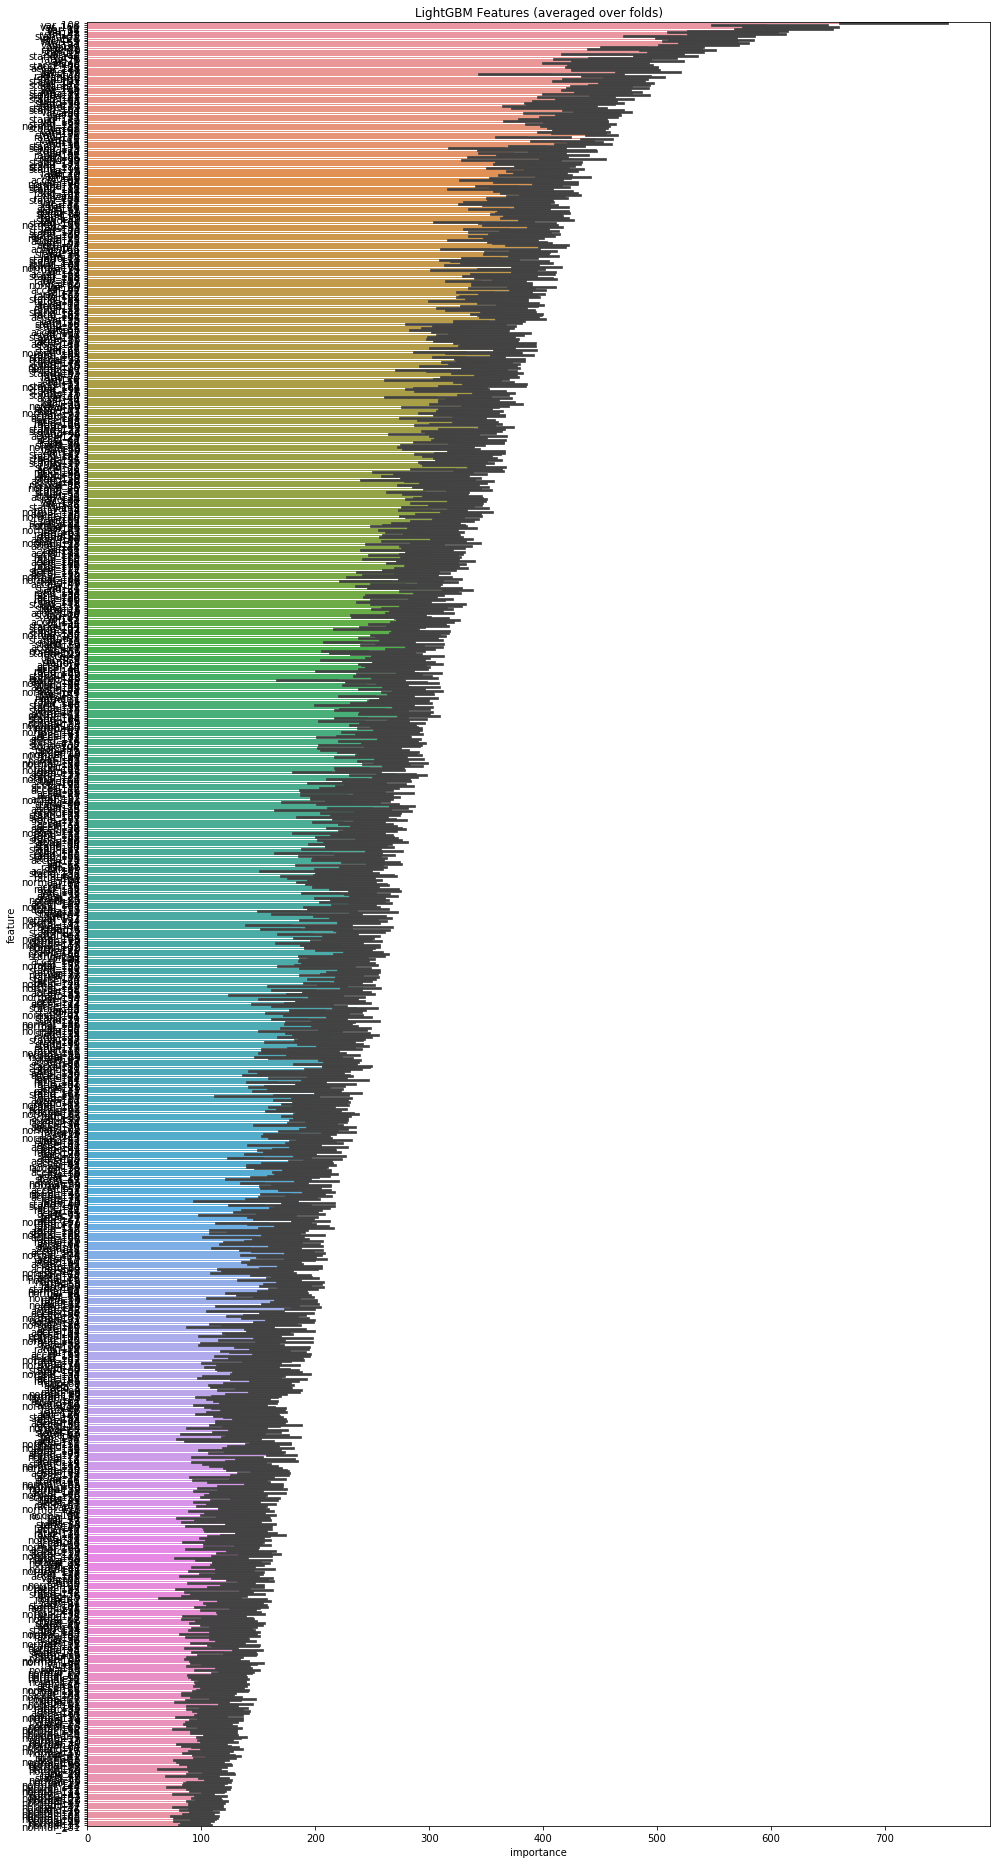

In [6]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

#### **五、写入预测结果**

In [8]:
# submission
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
predictions.to_csv('lgb_all_predictions.csv', index=None)
sub_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
sub_df["target"] = predictions['target']
sub_df.to_csv("lgb_submission.csv", index=False)
oof.to_csv('lgb_oof.csv', index=False)

In [9]:
result = pd.DataFrame()
result = predictions[["ID_code", "target"]]

In [11]:
result.to_csv("./result.csv", index=False)